<a href="https://colab.research.google.com/github/peremartra/llama-glu-expansion-pruning/blob/main/notebooks/04_1B_Graphics_Carbon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLU Pruning Research - Llama-3.2-1B Inference Analysis
## 05 - Visualization and Analysis of Inference & Carbon Results

### Exploring the "Deployment Dilemma": Batch Throughput vs. Interactive Latency
by [Pere Martra](https://github.com/peremartra)

[![Paper](https://img.shields.io/badge/OSF-Paper-blue?logo=osf&logoColor=white)](https://doi.org/10.31219/osf.io/qgxea)
[![GitHub](https://img.shields.io/badge/⭐_Star-OptiPFair-orange?logo=github&logoColor=white)](https://github.com/peremartra/optipfair)
[![PyPI](https://img.shields.io/pypi/v/optipfair?logo=python&logoColor=white&label=v)](https://pypi.org/project/optipfair/)

**Repository:** [github.com/peremartra/llama-glu-expansion-pruning](https://github.com/peremartra/llama-glu-expansion-pruning)

---

**Colab Environment:** CPU (no GPU required for visualization)

**Estimated Runtime:** ~1 minute
## Objective
This notebook loads the complete carbon and inference performance results for the Llama-3.2-1B model from `llama_1b_carbon_complete_results_latest.json`.

The primary goal is to visualize the impact of pruning on deployment metrics. We will use the **`expansion_rate`** as the primary independent variable (X-axis) to explore our "Deployment Dilemma" hypothesis: that pruning creates a trade-off, dramatically improving **batch throughput** and **energy efficiency** at the cost of **interactive latency (Time To First Token)**.

In [1]:
# === 1. Setup & Imports ===

# Install necessary libraries
!pip install pandas matplotlib seaborn

# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Configure plots for better readability
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# === 2. Load Data ===

import os
import json

# Download llama_1b_carbon_complete_results_latest.json from GitHub repository
print("Downloading results file...")
file_name = 'llama_1b_carbon_complete_results_latest.json'
!wget -q https://raw.githubusercontent.com/peremartra/llama-glu-expansion-pruning/main/results/llama_1b_carbon_complete_results_latest.json

# Verify download
if os.path.exists(file_name):
    print(f"✅ {file_name} downloaded successfully")
else:
    print(f"❌ Failed to download {file_name}")

# Load the JSON data
try:
    with open(file_name, 'r') as f:
        data = json.load(f)
    print("File loaded successfully into 'data' variable.")
    # Set data entry points
    models_data = data.get('models_evaluated', {})
    summary_data = data.get('summary_statistics', {})
except Exception as e:
    print(f"ERROR: Could not read or parse JSON file. {e}")
    data = None
    models_data = {}
    summary_data = {}

✅ llama_1b_carbon_complete_results_latest.json downloaded successfully
File loaded successfully into 'data' variable.


In [3]:
# === 3. Data Preprocessing (Summary Data) ===
# This DataFrame is for the main graphs, using the pre-calculated averages.

# This mapping is from our first JSON file and is crucial for the X-axis
expansion_rate_map = {
    0: 4.0,
    10: 3.6,
    20: 3.2,
    30: 2.8,
    40: 2.4,
    50: 2.0,
    60: 1.6
}

summary_list = []

# Add baseline data
if 'baseline' in summary_data:
    baseline = summary_data['baseline']
    pruning_pct = baseline.get('pruning_pct', 0)
    baseline_row = {
        'model': baseline.get('model'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),
        'avg_throughput_tok_s': baseline.get('avg_throughput_tok_s'),
        'avg_joules_per_token': baseline.get('avg_joules_per_token'),
        'avg_ttft_ms': baseline.get('avg_ttft_ms'),
        'model_size_gb': baseline.get('model_size_gb')
    }
    summary_list.append(baseline_row)

# Add pruned models data
for model in summary_data.get('pruned_models', []):
    pruning_pct = model.get('pruning_pct', 0)
    row = {
        'model': model.get('model'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),
        'avg_throughput_tok_s': model.get('avg_throughput_tok_s'),
        'avg_joules_per_token': model.get('avg_joules_per_token'),
        'avg_ttft_ms': model.get('avg_ttft_ms'),
        'model_size_gb': model.get('model_size_gb')
    }
    summary_list.append(row)

# Create DataFrame and sort by expansion_rate (descending)
df_summary = pd.DataFrame(summary_list)
df_summary = df_summary.sort_values(by='expansion_rate', ascending=False).reset_index(drop=True)

print("Summary DataFrame created successfully:")
df_summary

Summary DataFrame created successfully:


,model,pruning_pct,expansion_rate,avg_throughput_tok_s,avg_joules_per_token,avg_ttft_ms,model_size_gb
0,Llama-3.2-1B,0,4.0,157.652744,0.168180,877.297377,2.301884
1,Llama-3.2-1B-pruned-10%,10,3.6,156.879342,0.172957,1006.675725,2.151920
2,Llama-3.2-1B-pruned-20%,20,3.2,159.308943,0.163641,1123.239053,2.001957
3,Llama-3.2-1B-pruned-30%,30,2.8,158.225858,0.157376,1312.353319,1.851994
4,Llama-3.2-1B-pruned-40%,40,2.4,159.684363,0.143711,1320.893753,1.702030
5,Llama-3.2-1B-pruned-50%,50,2.0,163.263240,0.139312,1400.906492,1.551884
6,Llama-3.2-1B-pruned-60%,60,1.6,162.378889,0.135205,1396.786216,1.401920


In [4]:
# === 4. Data Preprocessing (Detailed Benchmarks) ===
# This DataFrame is for the detailed breakdown graphs in Section 2.

all_results = []

for model_key, v in models_data.items():
    results = v.get('results', {})
    pruning_pct = v.get('pruning_pct', 0)

    # Get metrics for a specific benchmark, handling potential missing data
    def get_metrics(benchmark_name):
        data = results.get(benchmark_name, {})
        return (
            data.get('throughput_mean'),
            data.get('ttft_mean'),
            data.get('joules_per_token_mean')
        )

    h_thr, h_ttf, h_j = get_metrics('hellaswag_latency_b1')
    m_thr, m_ttf, m_j = get_metrics('mmlu_latency_b1')
    i_thr, i_ttf, i_j = get_metrics('ifeval_latency_b1')

    h_thr_b8, _, h_j_b8 = get_metrics('hellaswag_throughput_b8') # TTFT is null for b8
    m_thr_b8, _, m_j_b8 = get_metrics('mmlu_throughput_b8')
    i_thr_b8, _, i_j_b8 = get_metrics('ifeval_throughput_b8')

    row = {
        'model': v.get('name'),
        'pruning_pct': pruning_pct,
        'expansion_rate': expansion_rate_map.get(pruning_pct),

        # bsz=1 (Latency)
        'hellaswag_latency_b1_throughput': h_thr,
        'hellaswag_latency_b1_ttft': h_ttf,
        'hellaswag_latency_b1_joules': h_j,
        'mmlu_latency_b1_throughput': m_thr,
        'mmlu_latency_b1_ttft': m_ttf,
        'mmlu_latency_b1_joules': m_j,
        'ifeval_latency_b1_throughput': i_thr,
        'ifeval_latency_b1_ttft': i_ttf,
        'ifeval_latency_b1_joules': i_j,

        # bsz=8 (Throughput)
        'hellaswag_throughput_b8_throughput': h_thr_b8,
        'hellaswag_throughput_b8_joules': h_j_b8,
        'mmlu_throughput_b8_throughput': m_thr_b8,
        'mmlu_throughput_b8_joules': m_j_b8,
        'ifeval_throughput_b8_throughput': i_thr_b8,
        'ifeval_throughput_b8_joules': i_j_b8,
    }
    all_results.append(row)

# Create DataFrame and sort
df_detailed = pd.DataFrame(all_results)
df_detailed = df_detailed.sort_values(by='expansion_rate', ascending=False).reset_index(drop=True)

print("Detailed DataFrame created successfully:")
df_detailed.head()

Detailed DataFrame created successfully:


,model,pruning_pct,expansion_rate,hellaswag_latency_b1_throughput,hellaswag_latency_b1_ttft,hellaswag_latency_b1_joules,mmlu_latency_b1_throughput,mmlu_latency_b1_ttft,mmlu_latency_b1_joules,ifeval_latency_b1_throughput,ifeval_latency_b1_ttft,ifeval_latency_b1_joules,hellaswag_throughput_b8_throughput,hellaswag_throughput_b8_joules,mmlu_throughput_b8_throughput,mmlu_throughput_b8_joules,ifeval_throughput_b8_throughput,ifeval_throughput_b8_joules
0,Llama-3.2-1B,0,4.0,49.532543,105.974294,0.281586,51.416682,824.382641,0.268144,51.741510,1701.535196,0.280417,242.947984,0.066662,275.165578,0.054892,275.112167,0.057379
1,Llama-3.2-1B-pruned-10%,10,3.6,49.950425,190.072531,0.277677,51.400207,778.302821,0.273158,51.061296,2051.651821,0.278099,240.535543,0.075594,270.889337,0.064758,277.439242,0.068458
2,Llama-3.2-1B-pruned-20%,20,3.2,50.740577,294.138728,0.262288,50.913983,769.436835,0.257700,51.792136,2306.141596,0.292465,253.320181,0.060004,275.405936,0.053220,273.680847,0.056170
3,Llama-3.2-1B-pruned-30%,30,2.8,50.603719,392.474771,0.247798,50.890286,907.107113,0.240674,51.399719,2637.478072,0.270273,248.016840,0.066645,273.341902,0.058555,275.102682,0.060310
4,Llama-3.2-1B-pruned-40%,40,2.4,50.263331,397.637547,0.229524,50.749259,929.433763,0.221957,51.400164,2635.609948,0.258762,257.985980,0.053583,274.482953,0.048111,273.224492,0.050326


## Section 1: Key Hypothesis Graphs (The "Deployment Dilemma")

This section visualizes the core trade-off. We use the `df_summary` DataFrame to plot the high-level averages.

1.  **Energy:** How does pruning affect `Joules/Token`?
2.  **Latency:** How does pruning affect `Time To First Token` (TTFT)?
3.  **The Dilemma:** How do `Throughput` and `TTFT` behave together?
4.  **The "Why":** How does `Model Size` correlate with `Throughput`?

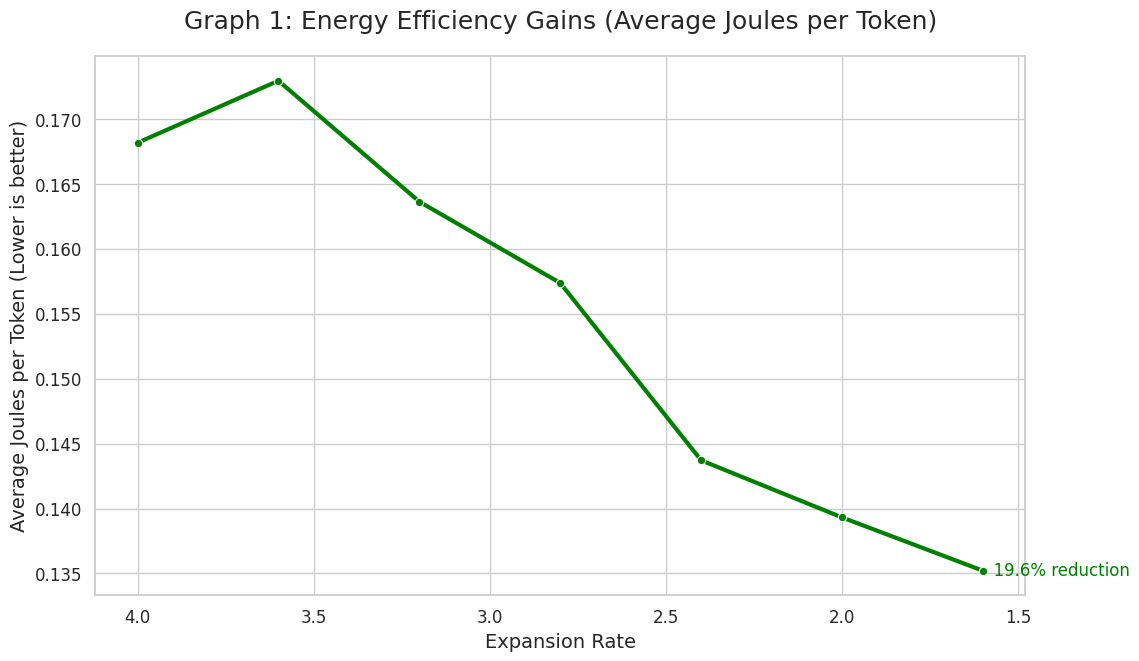

In [5]:
# === Graph 1: The Great Win - Energy Efficiency (Joules/Token) ===

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=df_summary,
    x='expansion_rate',
    y='avg_joules_per_token',
    marker='o',
    linewidth=3,
    color='green'
)

ax.invert_xaxis() # Ensure 4.0 (baseline) is on the left
ax.set_title('Graph 1: Energy Efficiency Gains (Average Joules per Token)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Average Joules per Token (Lower is better)')

# Annotate percentage reduction
baseline_joules = df_summary.iloc[0]['avg_joules_per_token']
final_joules = df_summary.iloc[-1]['avg_joules_per_token']
reduction_pct = (1 - final_joules / baseline_joules) * 100
ax.text(1.6, final_joules, f'  {reduction_pct:.1f}% reduction',
        horizontalalignment='left', verticalalignment='center', fontsize=12, color='green')

plt.show()

This graph, **"Graph 1: Energy Efficiency Gains (Average Joules per Token)"**, illustrates the gain in energy efficiency as the model's "Expansion Rate" is reduced.

* **X-Axis (Expansion Rate):** Shows the models from the baseline (4.0) on the left, to the model with the most pruning (1.6) on the right.
* **Y-Axis (Average Joules per Token):** Measures the energy cost per token generated. A **lower value is better**.

The visualization shows a **clear downward trend, with a dip at the 3.6x expansion model**. This indicates that as we reduce the "Expansion Rate" (that is, we apply more pruning), the model consumes less per token generated.

The key point, highlighted in the annotation, is that the model with the most aggressive pruning (1.6 Expansion Rate) achieves a **total reduction in energy consumption of 19.5%** compared to the baseline model.

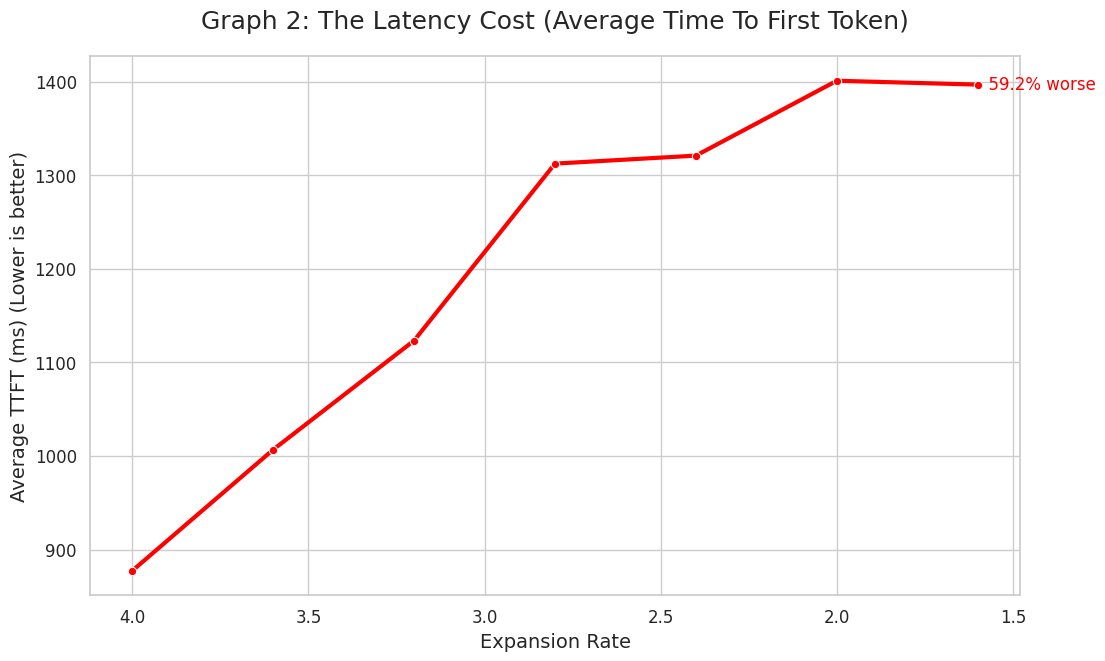

In [6]:
# === Graph 2: The Great Loss - Interactive Latency (TTFT) ===

plt.figure(figsize=(12, 7))
ax = sns.lineplot(
    data=df_summary,
    x='expansion_rate',
    y='avg_ttft_ms',
    marker='o',
    linewidth=3,
    color='red'
)

ax.invert_xaxis()
ax.set_title('Graph 2: The Latency Cost (Average Time To First Token)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Average TTFT (ms) (Lower is better)')

# Annotate percentage increase
baseline_ttft = df_summary.iloc[0]['avg_ttft_ms']
final_ttft = df_summary.iloc[-1]['avg_ttft_ms']
increase_pct = (final_ttft / baseline_ttft - 1) * 100
ax.text(1.6, final_ttft, f'  {increase_pct:.1f}% worse',
        horizontalalignment='left', verticalalignment='center', fontsize=12, color='red')

plt.show()

This graph, **"Graph 2: The Latency Cost"**, illustrates the negative impact of pruning on interactive latency, measured as the "Time To First Token" (TTFT).

* **X-Axis (Expansion Rate):** Goes from the baseline model (4.0) to the most pruned (1.6).
* **Y-Axis (Average TtFT):** Measures the time in milliseconds it takes the model to generate the first response. A **lower value is better**.

The ascending red line shows that as the "Expansion Rate" is reduced (more pruning), the waiting time (TTFT) **worsens significantly**. The model with the most aggressive pruning (1.6) is **59.2% slower** to respond initially than the baseline model.

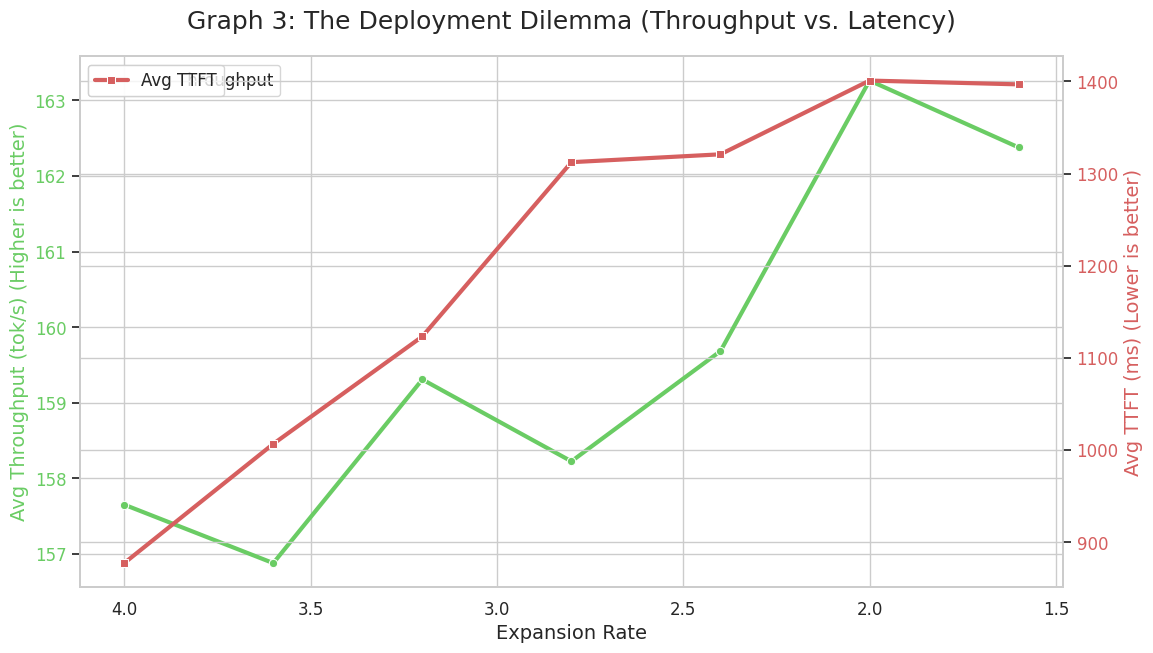

In [7]:
# === Graph 3: The Deployment Dilemma (Throughput vs. Latency) ===

fig, ax1 = plt.subplots(figsize=(12, 7))
plt.title('Graph 3: The Deployment Dilemma (Throughput vs. Latency)', fontsize=18, pad=20)

# Plot Avg Throughput (Higher is better)
color1 = 'g'
ax1.set_xlabel('Expansion Rate')
ax1.set_ylabel('Avg Throughput (tok/s) (Higher is better)', color=color1, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_throughput_tok_s', ax=ax1, color=color1, marker='o', linewidth=3, label='Avg Throughput')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.invert_xaxis()

# Create second Y-axis for TTFT (Lower is better)
ax2 = ax1.twinx()
color2 = 'r'
ax2.set_ylabel('Avg TTFT (ms) (Lower is better)', color=color2, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_ttft_ms', ax=ax2, color=color2, marker='s', linewidth=3, label='Avg TTFT')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout(pad=2.0)
plt.show()

This graph, **"Graph 3: The Deployment Dilemma"**, is the most important one, as it visualizes the central *trade-off* of pruning in inference.

* **X-Axis (Expansion Rate):** Shows the models from the baseline (4.0) to the most pruned (1.6).
* **Left Y-Axis (Green):** Measures "Avg Throughput" (tokens/sec), where **higher is better**.
* **Right Y-Axis (Red):** Measures "Avg TTFT" (milliseconds), where **lower is better**.

The graph shows a clear dilemma:
1.  **Green Line (Throughput):** Goes up as the model is pruned. This is an **improvement** for batch processing.
2.  **Red Line (TTFT):** Also goes up (worsens) as the model is pruned. This is a **detriment** to interactive latency.

In summary, pruning improves batch performance (more tokens/sec overall) but at the cost of worse initial latency (more waiting time for the user).

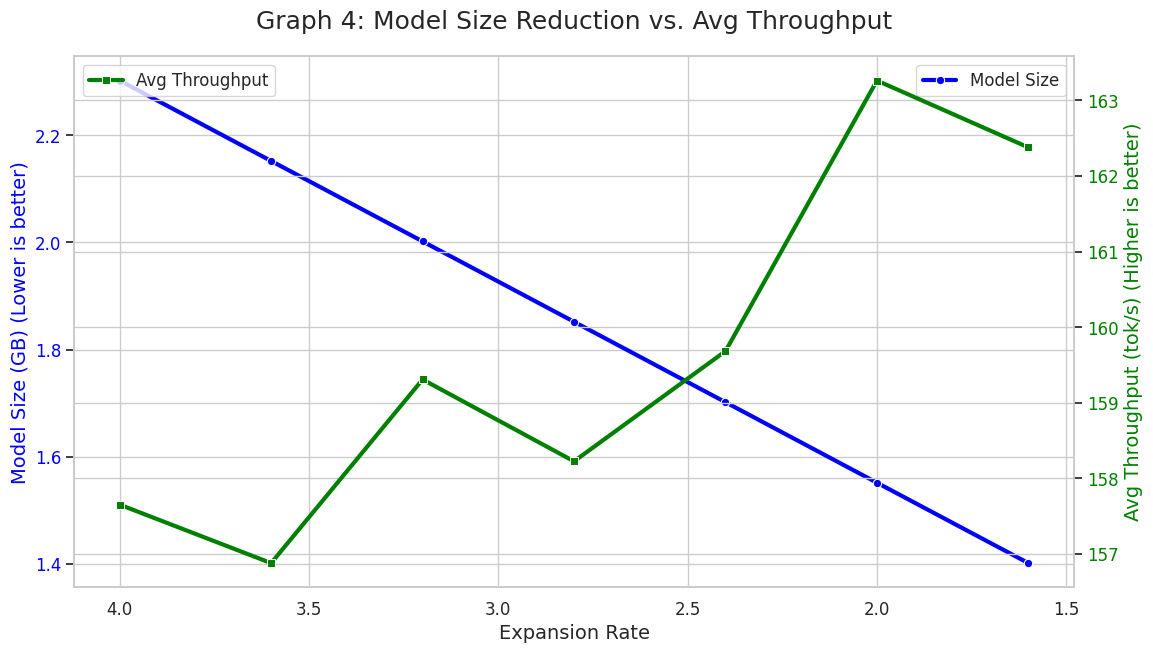

In [8]:
# === Graph 4: The "Why" - Model Size vs. Throughput ===

fig, ax1 = plt.subplots(figsize=(12, 7))
plt.title('Graph 4: Model Size Reduction vs. Avg Throughput', fontsize=18, pad=20)

# Plot Model Size (Lower is better)
color1 = 'blue'
ax1.set_xlabel('Expansion Rate')
ax1.set_ylabel('Model Size (GB) (Lower is better)', color=color1, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='model_size_gb', ax=ax1, color=color1, marker='o', linewidth=3, label='Model Size')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.invert_xaxis()

# Create second Y-axis for Throughput (Higher is better)
ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Avg Throughput (tok/s) (Higher is better)', color=color2, fontsize=14)
sns.lineplot(data=df_summary, x='expansion_rate', y='avg_throughput_tok_s', ax=ax2, color=color2, marker='s', linewidth=3, label='Avg Throughput')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout(pad=2.0)
plt.show()

This graph, **"Graph 4: Model Size Reduction vs. Avg Throughput"**, explains *why* batch performance improves.

* **Left Y-Axis (Blue):** Measures the "Model Size (GB)". A **lower** value **is better**.
* **Right Y-Axis (Green):** Measures the "Avg Throughput" (tokens/sec). A **higher** value **is better**.

The graph shows a perfect inverse correlation: as the "Expansion Rate" is reduced (more pruning), the model size (blue line) **decreases**, and as a direct result, the throughput (green line) **increases**. A smaller model is processed faster in batches.

## Section 2: Exploratory Graphs (Detailed Benchmark Breakdown)

This section uses the `df_detailed` DataFrame to explore performance on a per-task basis. This helps us confirm if the trends seen in the averages hold true for short, medium, and long tasks.

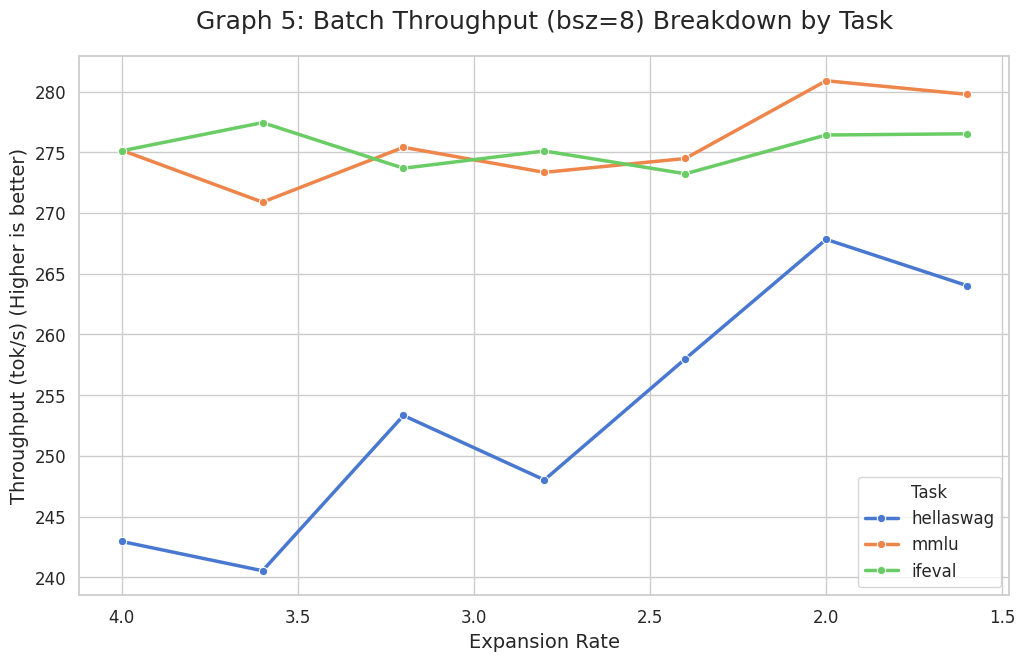

In [9]:
# === Graph 5: Batch Throughput (bsz=8) Breakdown ===
# Purpose: Check if batch throughput gains are consistent across tasks.

df_melted_b8_thr = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_throughput_b8_throughput',
        'mmlu_throughput_b8_throughput',
        'ifeval_throughput_b8_throughput'
    ],
    var_name='Benchmark',
    value_name='Throughput (tok/s)'
)
# Clean up names
df_melted_b8_thr['Task'] = df_melted_b8_thr['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b8_thr, x='expansion_rate', y='Throughput (tok/s)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 5: Batch Throughput (bsz=8) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Throughput (tok/s) (Higher is better)')
plt.show()

This graph, **"Graph 5: Batch Throughput (bsz=8) Breakdown by Task"**, breaks down the batch throughput (batch size = 8) for each individual evaluation task.

* **X-Axis (Expansion Rate):** Shows the models from the baseline (4.0) on the left, to the model with the most pruning (1.6) on the right.
* **Y-Axis (Throughput (tok/s)):** Measures the processing speed. A **higher** value **is better**.

The visualization indicates that, while no task is harmed, the upward trend of the *throughput* is not uniform. The impact of pruning on batch performance varies by task:

* **Hellaswag** (blue) shows the most pronounced increase, starting at ~243 tok/s (baseline 4.0) and ending at ~268 tok/s (expansion 1.6).
* **MMLU** (orange) and **Ifeval** (green) remain **relatively stable**. MMLU shows a slight gain (from ~275 to ~281 tok/s), while Ifeval remains almost flat (from ~275 to ~276 tok/s).

This confirms that the average *throughput* improvement (seen in Graph 3) is valid, but it is driven mainly by performance on tasks like Hellaswag (short text generation), while other tasks see a more limited benefit.

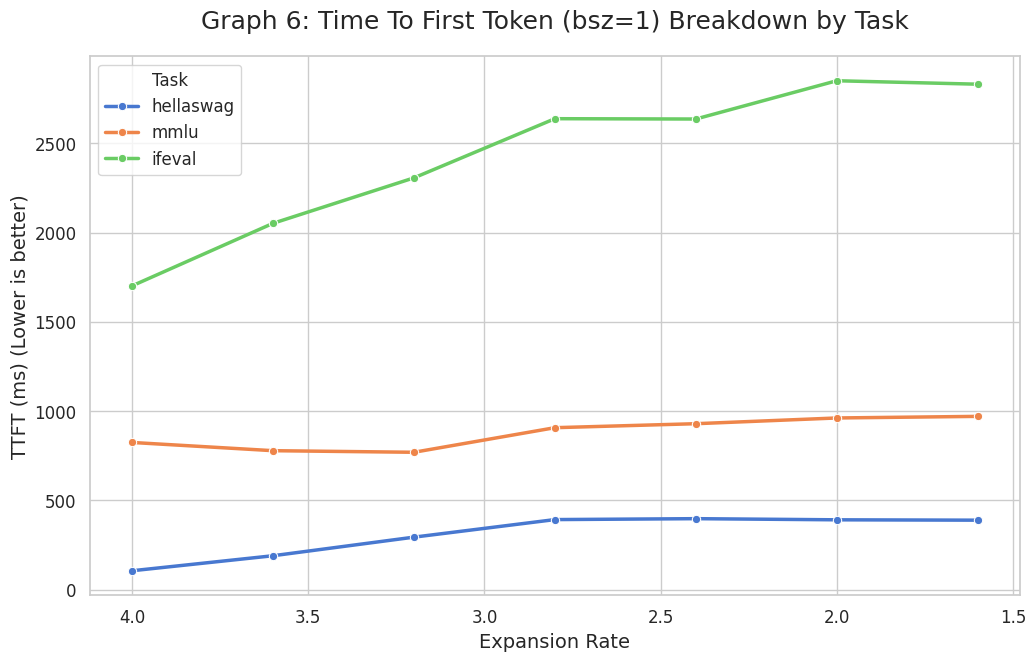

In [10]:
# === Graph 6: Time To First Token (bsz=1) Breakdown ===
# Purpose: Check if the TTFT cost is consistent across tasks.

df_melted_b1_ttft = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_latency_b1_ttft',
        'mmlu_latency_b1_ttft',
        'ifeval_latency_b1_ttft'
    ],
    var_name='Benchmark',
    value_name='TTFT (ms)'
)
# Clean up names
df_melted_b1_ttft['Task'] = df_melted_b1_ttft['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b1_ttft, x='expansion_rate', y='TTFT (ms)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 6: Time To First Token (bsz=1) Breakdown by Task', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('TTFT (ms) (Lower is better)')
plt.show()

This graph, **"Graph 6: Time To First Token (bsz=1) Breakdown by Task"**, breaks down the impact of pruning on interactive latency (TTFT) for individual tasks, using a batch size of 1.

* **X-Axis (Expansion Rate):** Represents the models from the baseline (4.0) to the one with the most pruning (1.6).
* **Y-Axis (TTFT (ms)):** Measures the time to generate the first token. A **lower** value **is better**.

The observed trend is consistent with Graph 2: pruning increases TTFT, worsening the initial response latency in all evaluated tasks. However, the magnitude of this impact differs depending on the task:

* **Hellaswag** (blue), which has the lowest base TTFT (~106 ms at 4.0), experiences the sharpest relative deterioration, increasing and stabilizing around ~390-400 ms between expansion rates 2.4 and 1.6.
* **MMLU** (orange) shows a constant but more moderate increase, going from ~824 ms in the baseline (4.0) to ~970 ms at expansion 1.6.
* **Ifeval** (green), the task with the longest input prompts, suffers the largest impact in absolute terms, increasing from ~1700 ms (baseline) to a maximum of ~2850 ms (expansion 1.6).

The analysis confirms that the cost in interactive latency (TTFT) is a generalized consequence of pruning, observable in tasks with short, medium, and long prompts.

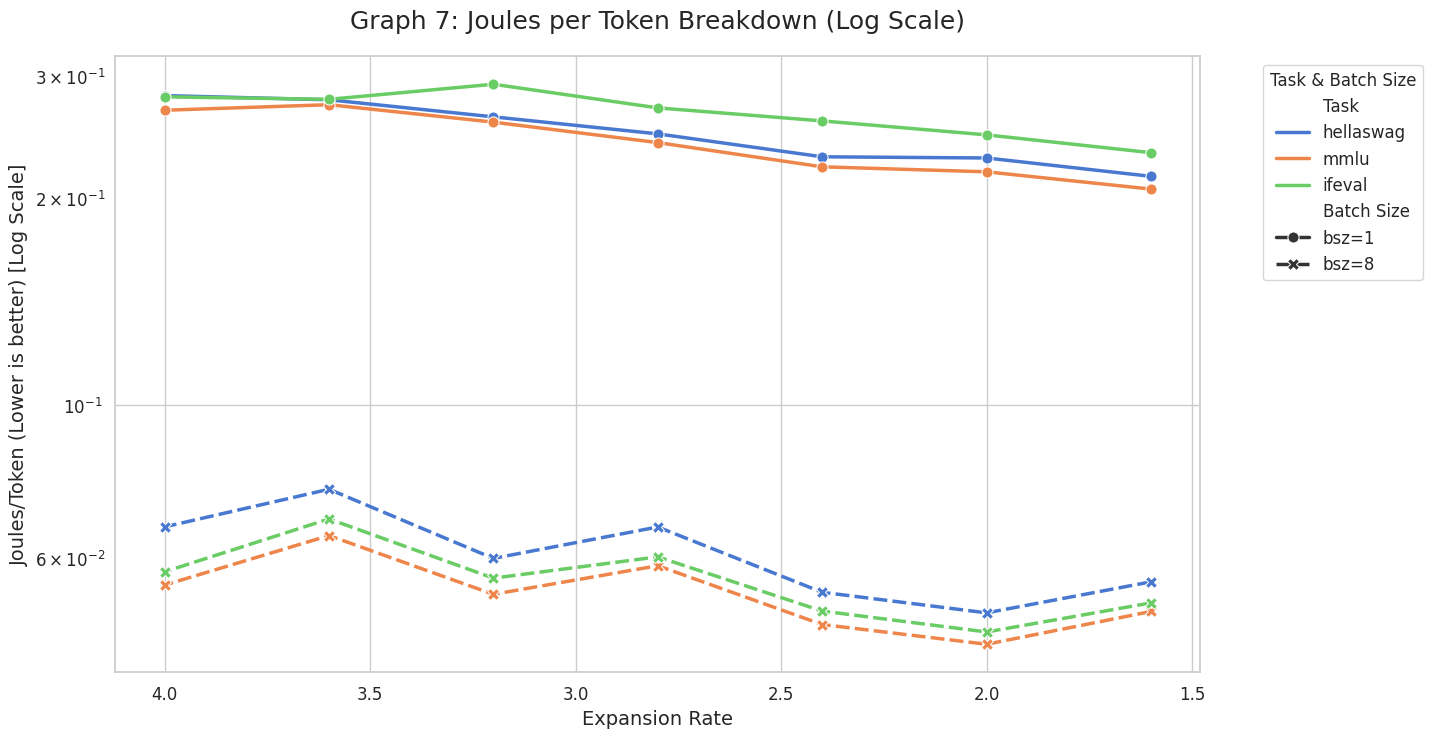

In [11]:
# === Graph 7: Joules per Token Breakdown (bsz=1 vs bsz=8) ===
# Purpose: Confirm efficiency gains across all tasks and batch sizes.

joules_cols = [col for col in df_detailed.columns if 'joules' in col]
df_melted_joules = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=joules_cols,
    var_name='Benchmark',
    value_name='Joules/Token'
)

# Create new columns for plotting
df_melted_joules['Batch Size'] = df_melted_joules['Benchmark'].apply(lambda x: 'bsz=1' if 'latency' in x else 'bsz=8')
df_melted_joules['Task'] = df_melted_joules['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=df_melted_joules,
    x='expansion_rate',
    y='Joules/Token',
    hue='Task',
    style='Batch Size',
    markers=True,
    linewidth=2.5,
    markersize=8
)

ax.set_yscale('log') # Use log scale to see both bsz=1 and bsz=8 clearly
ax.invert_xaxis()
ax.set_title('Graph 7: Joules per Token Breakdown (Log Scale)', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Joules/Token (Lower is better) [Log Scale]')
plt.legend(title='Task & Batch Size', bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

This graph, **"Graph 7: Joules per Token Breakdown (Log Scale)"**, breaks down the energy cost (Joules/Token) by task and by batch size.

* **X-Axis (Expansion Rate):** Represents the models from the baseline (4.0) to the most pruned (1.6).
* **Y-Axis (Joules/Token [Log Scale]):** Measures the energy cost on a logarithmic scale. A **lower** value **is better**.
* **Line Style:** The solid lines represent `bsz=1` (interactive latency), and the dashed lines `bsz=8` (batch performance).

This breakdown confirms several key observations:

1.  **Batch Efficiency:** There is a significant separation between the two deployment modes. The dashed lines (bsz=8) are notably below the solid lines (bsz=1), which confirms that batch processing is inherently more energy efficient per token (approximately 0.14-0.17 J/tok for bsz=1 versus 0.05-0.07 J/tok for bsz=8 in the baseline).
2.  **Impact of Pruning (bsz=8):** All tasks at `bsz=8` (dashed) show a downward trend as the "Expansion Rate" is reduced.
3.  **Impact of Pruning (bsz=1):** The tasks at `bsz=1` (solid) also show a general downward trend, indicating an efficiency improvement. A slight anomaly is observed in Hellaswag (solid blue line) at the 3.6 expansion, which shows a slight increase in cost before continuing its descent.

In conclusion, the graph validates that the energy efficiency gain (reduction in Joules/Token) observed in Graph 1 is a robust result, applicable to both batch and interactive processing across the different evaluated tasks.

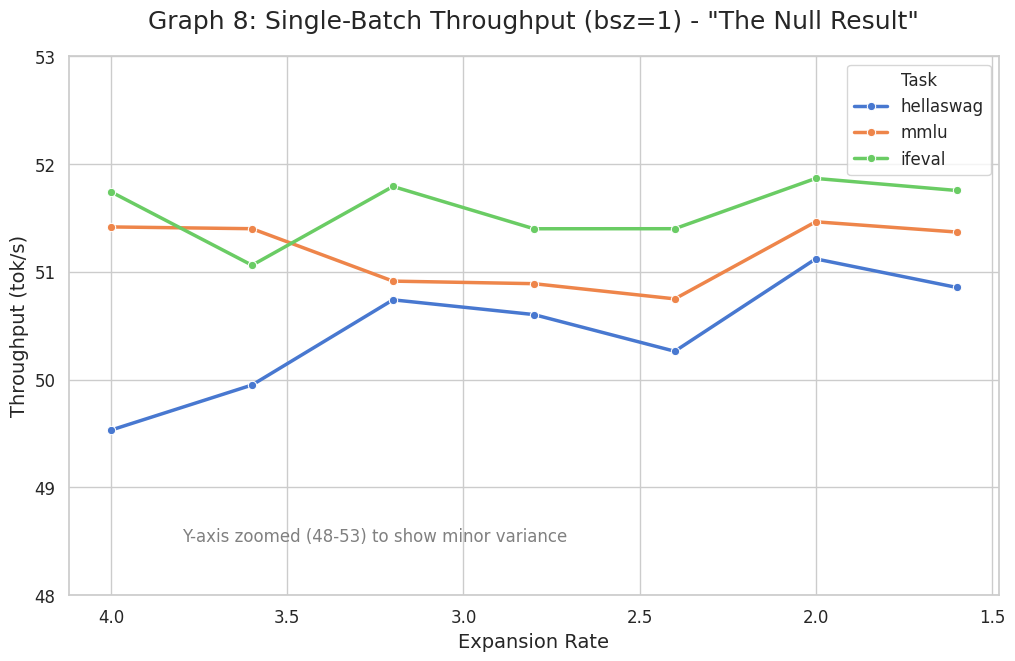

In [12]:
# === Graph 8: Single-Batch Throughput (bsz=1) "Null Result" ===
# Purpose: Show that single-token generation speed is not the bottleneck or the benefit.

df_melted_b1_thr = df_detailed.melt(
    id_vars=['expansion_rate'],
    value_vars=[
        'hellaswag_latency_b1_throughput',
        'mmlu_latency_b1_throughput',
        'ifeval_latency_b1_throughput'
    ],
    var_name='Benchmark',
    value_name='Throughput (tok/s)'
)
# Clean up names
df_melted_b1_thr['Task'] = df_melted_b1_thr['Benchmark'].str.split('_', expand=True)[0]

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_melted_b1_thr, x='expansion_rate', y='Throughput (tok/s)', hue='Task', marker='o', linewidth=2.5)
ax.invert_xaxis()
ax.set_title('Graph 8: Single-Batch Throughput (bsz=1) - "The Null Result"', fontsize=18, pad=20)
ax.set_xlabel('Expansion Rate')
ax.set_ylabel('Throughput (tok/s)')

# Set Y-axis limit to highlight the flatness
ax.set_ylim(48, 53)
ax.text(3.8, 48.5, 'Y-axis zoomed (48-53) to show minor variance', fontsize=12, color='gray')

plt.show()

This graph, **"Graph 8: Single-Batch Throughput (bsz=1) - 'The Null Result'"**, examines the token generation speed (throughput) in an interactive scenario (batch size = 1) for each task.

* **X-Axis (Expansion Rate):** Shows the models from the baseline (4.0) to the most pruned (1.6).
* **Y-Axis (Throughput (tok/s)):** Measures the token generation speed. A **higher** value **is better**.

The main observation from this graph is the **absence of a significant trend**. The lines for hellaswag (blue), mmlu (orange), and ifeval (green) remain notably flat, grouped in a very narrow range between ~50 and ~52 tok/s across all pruning levels.

As noted in the graph's code, the Y-axis has been deliberately adjusted (48-53 tok/s) to be able to visualize these minor variations.

This "null result" is key: it demonstrates that, while pruning drastically worsens the *initial response time* (TTFT), **it does not have a relevant impact on the generation speed of subsequent tokens** in interactive mode.

## 📊 Session Summary: Inference and Carbon Analysis (1B)

This notebook has visualized the inference performance and carbon consumption data for the pruned Llama-3.2-1B models, loaded from `llama_1b_carbon_complete_results_latest.json`. The analysis focused on the "Deployment Dilemma": the hypothesis that pruning (reducing the `expansion_rate`) benefits batch performance at the cost of interactive latency.

The key findings from the graphs are as follows:

### 1. The Deployment Dilemma: Confirmed

The analysis validates the central hypothesis:

* **Benefit (Throughput):** The average batch throughput (`avg_throughput_tok_s`) shows a tendency to increase as the `expansion_rate` is reduced (more pruning).
* **Cost (Latency):** The average interactive latency (`avg_ttft_ms`) shows a clear worsening, increasing significantly as the `expansion_rate` is reduced.

**Graph 3** visualizes this dilemma directly, showing the two metrics diverging: batch throughput (green) improves while TTFT (red) worsens.

### 2. Energy Efficiency: A Clear Gain

Pruning offers a significant and consistent benefit in energy efficiency:

* **Overall Gain:** **Graph 1** shows a clear downward trend in `avg_joules_per_token`. The model with an `expansion_rate` of 1.6 (60% pruning) is **19.6% more efficient** energetically than the baseline.
* **Breakdown:** **Graph 7** confirms that this efficiency gain is robust. The reduction in Joules/Token is observed across all tasks (hellaswag, mmlu, ifeval) and in both deployment modes (`bsz=1` and `bsz=8`).

### 3. Detailed Performance Analysis

* **Cause of Throughput (Graph 4):** The improvement in `avg_throughput_tok_s` is directly correlated with the reduction in `model_size_gb`. As the model becomes smaller (blue line), the batch throughput increases (green line).
* **Throughput Breakdown (Graph 5):** The gain in `bsz=8` is not uniform. It is more pronounced in tasks with short prompts (hellaswag), while in tasks with longer prompts (mmlu, ifeval) the benefit is marginal or almost nil.
* **TTFT Breakdown (Graph 6):** The latency cost (`bsz=1`) affects all tasks. The impact is more severe in absolute terms (ms) for tasks with long prompts (ifeval) and more severe in relative terms (%) for tasks with short prompts (hellaswag).

### 4. The "Null Result": Latency Isolation

**Graph 8** provides a crucial insight. It shows that the *throughput* at `bsz=1` (the token generation speed *after* the first) remains almost perfectly flat across all pruning levels.

This demonstrates that the negative impact of pruning on latency is not due to slower generation, but is **isolated almost completely in the 'Time To First Token' (TTFT)**.

### Session Conclusion

Pruning Llama-3.2-1B reduces the `expansion_rate`, which decreases the model size and significantly improves energy efficiency (Joules/Token) in all scenarios. This improves batch performance (bsz=8). However, this benefit comes at a direct and severe cost: a drastic increase in the initial response time (TTFT), although the subsequent token generation speed remains intact.